# The Log Polar Transform In Practice
> How to use the Log Polar Transform to find the relative rotation between two images.

- toc: true 
- badges: true
- comments: true
- categories: [Computer Vision]
- image: images/2020-12-22-The-Log-Polar-Transform-In-Practice/header.jpg

## The Context


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import skimage.io
import skimage.transform

from skimage.color import rgb2gray
import skimage.filters
from scipy.fftpack import fft2, fftshift

import skimage.registration 

plt.rcParams['figure.figsize'] = [10, 10]

### Cross Correlation Function

In [2]:
def phase_cross_correlation(reference_image, moving_image):
    src_freq = np.fft.fftn(reference_image)
    target_freq = np.fft.fftn(moving_image)

    # Whole-pixel shift - Compute cross-correlation by an IFFT
    shape = src_freq.shape
    image_product = src_freq * target_freq.conj()
    cross_correlation = np.fft.ifftn(image_product)
    
    # Locate maximum
    maxima = np.unravel_index(np.argmax(np.abs(cross_correlation)),
                              cross_correlation.shape)
    midpoints = np.array([np.fix(axis_size / 2) for axis_size in shape])

    shifts = np.array(maxima, dtype=np.float64)
    shifts[shifts > midpoints] -= np.array(shape)[shifts > midpoints]
    
    return np.abs(cross_correlation), shifts

In [3]:
frame = skimage.io.imread('data/2020-12-20-The-Log-Polar-Transform/Frame.jpg')
img1 = rgb2gray(frame[50:165,55:170])
img1 -= img1.mean()

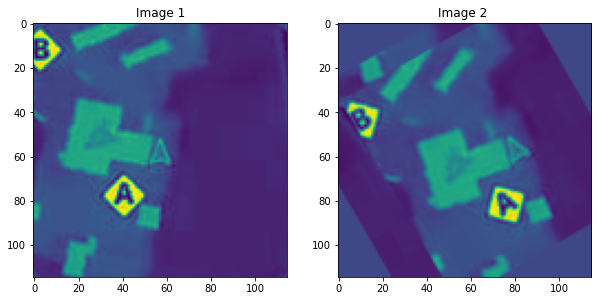

In [4]:
angle = 30 #degrees
shift_y = 10 #pixels
shift_x = 20 #pixels

translated = np.roll(img1, shift_y, axis=0)
translated = np.roll(translated, shift_x, axis=1)

img2 = skimage.transform.rotate(translated, angle)

fig, axes = plt.subplots(1, 2)
ax = axes.ravel()
ax[0].set_title("Image 1")
ax[0].imshow(img1)
ax[1].set_title("Image 2 ")
ax[1].imshow(img2)
plt.show()

## Finding the Rotation

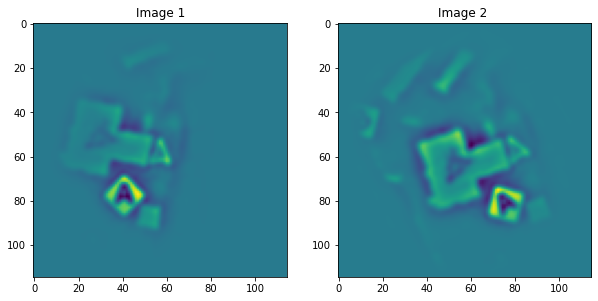

In [5]:
# First, band-pass filter both images
img1_dog = skimage.filters.difference_of_gaussians(img1, 1, 4)
img2_dog = skimage.filters.difference_of_gaussians(img2, 1, 4)

# window images
wimage_1 = img1_dog * skimage.filters.window('hann', img1.shape)
wimage_2 = img2_dog * skimage.filters.window('hann', img2.shape)

fig, axes = plt.subplots(1, 2)
ax = axes.ravel()
ax[0].set_title("Image 1")
ax[0].imshow(wimage_1)
ax[1].set_title("Image 2 ")
ax[1].imshow(wimage_2)
plt.show()

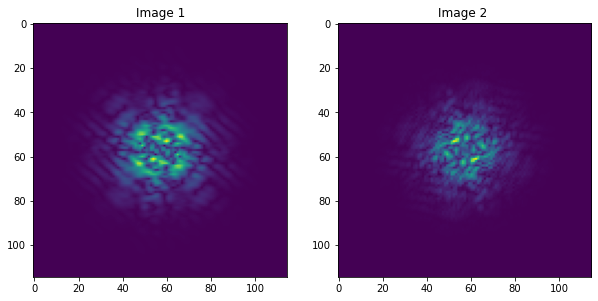

In [6]:
# work with shifted FFT magnitudes
image1_fs = np.abs(fftshift(fft2(wimage_1)))
image2_fs = np.abs(fftshift(fft2(wimage_2)))

fig, axes = plt.subplots(1, 2)
ax = axes.ravel()
ax[0].set_title("Image 1")
ax[0].imshow(image1_fs)
ax[1].set_title("Image 2 ")
ax[1].imshow(image2_fs)
plt.show()

### Log Polar Transform

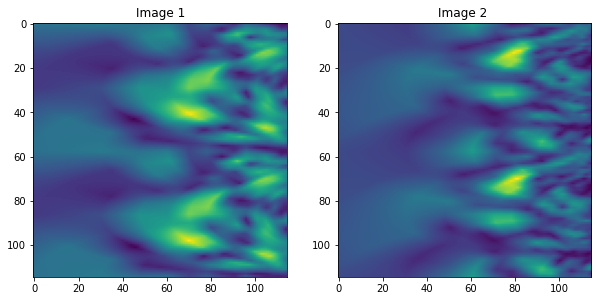

In [7]:
# Create log-polar transformed FFT mag images and register
shape = image1_fs.shape
radius = shape[0] // 8  # only take lower frequencies

warped_image1_fs = skimage.transform.warp_polar(image1_fs, radius=radius, output_shape=shape,
                             scaling='log', order=1)

warped_image2_fs = skimage.transform.warp_polar(image2_fs, radius=radius, output_shape=shape,
                           scaling='log', order=1)


fig, axes = plt.subplots(1, 2)
ax = axes.ravel()
ax[0].set_title("Image 1")
ax[0].imshow(warped_image1_fs)
ax[1].set_title("Image 2 ")
ax[1].imshow(warped_image2_fs)
plt.show()

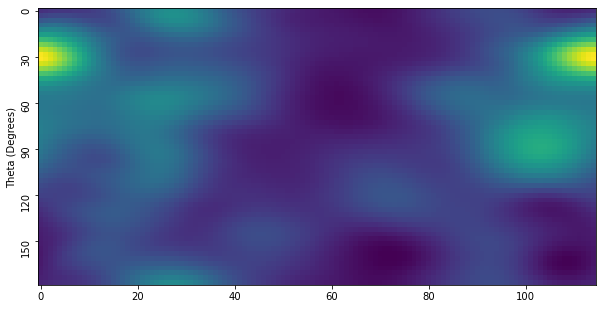

In [8]:
warped_image1_fs = warped_image1_fs[:shape[0] // 2, :]  # only use half of FFT
warped_image2_fs = warped_image2_fs[:shape[0] // 2, :]

cross_correlation, shifts = phase_cross_correlation(warped_image1_fs, warped_image2_fs)


labels =  np.arange(0,180,30)
y = labels/(180 / cross_correlation.shape[0])


plt.imshow(cross_correlation)
plt.yticks(y, labels, rotation='vertical')
plt.ylabel('Theta (Degrees)')

plt.show()

Expected value for cc rotation in degrees: 30
Recovered value for cc rotation: 31.304347826086957


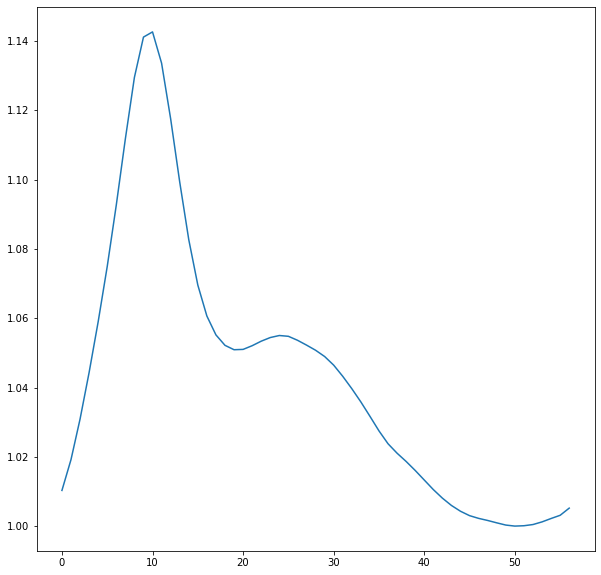

In [9]:
# Use translation parameters to calculate rotation and scaling parameters
recovered_angle = (360 / shape[0]) * shifts[0]

print(f"Expected value for cc rotation in degrees: {angle}")
print(f"Recovered value for cc rotation: {recovered_angle}")

plt.plot(cross_correlation[:,0].ravel()/np.min(cross_correlation[:,0].ravel()))
plt.show()

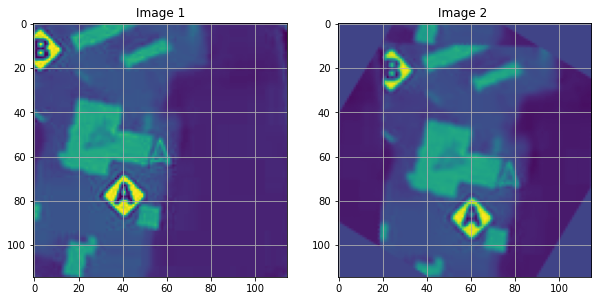

In [10]:
img2_rotated = skimage.transform.rotate(img2, -recovered_angle)

fig, axes = plt.subplots(1, 2)
ax = axes.ravel()
ax[0].set_title("Image 1")
ax[0].imshow(img1)
ax[0].grid()
ax[1].set_title("Image 2 ")
ax[1].imshow(img2_rotated)
ax[1].grid()
plt.show()



## Finding the Translation

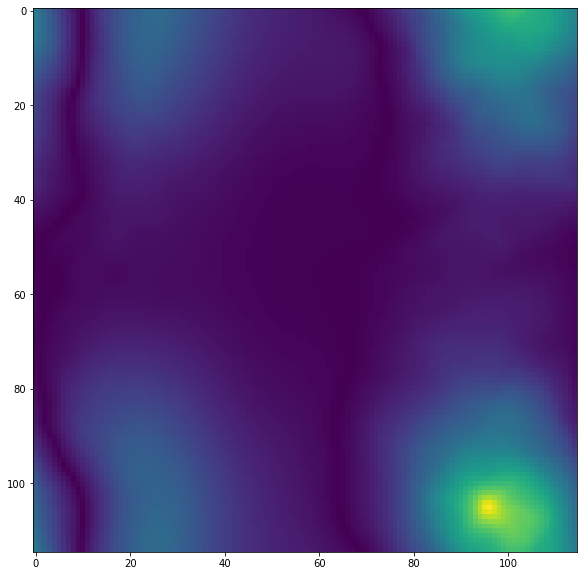

In [11]:
wimage_1 = img1 * skimage.filters.window('hann', img1.shape)
wimage_2_rotated = img2_rotated * skimage.filters.window('hann',img2.shape)
cross_correlation, shift = phase_cross_correlation(wimage_1, wimage_2_rotated)



plt.imshow(cross_correlation)
plt.show()

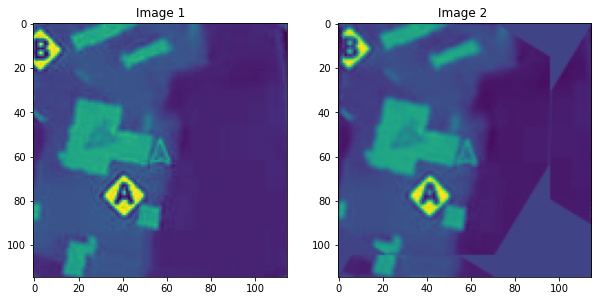

In [12]:
shift_x =  int(shift[1])
shift_y =  int(shift[0])

translated = np.roll(img2_rotated, shift_y, axis=0)
translated = np.roll(translated, shift_x, axis=1)


fig, axes = plt.subplots(1, 2)
ax = axes.ravel()
ax[0].set_title("Image 1")
ax[0].imshow(img1)
ax[1].set_title("Image 2 ")
ax[1].imshow(translated)
plt.show()

## Conclusion